In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import scipy.io
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import random
from sklearn.model_selection import train_test_split
import pandas as pd
from torch.nn import init

In [2]:
read_temp=scipy.io.loadmat(r"C:\Users\Administrator\Desktop\DEEPDOA\code\data2train\data2_trainlow.mat")
S_est=read_temp['S_est']                   #shape:(19800, 120, 2)
#S_abs=read_temp['S_abs']                   #shape:(19800,240)
S_label=read_temp['S_label']               #(19800,120)                     
S_label1 = np.expand_dims(S_label, 2)      #(19800,120,1)

In [17]:
nb_epoch=300
batch_size=120
batch_size_test = 60

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [19]:
S_est_train, S_est_test, S_label1_train, S_label1_test = train_test_split(S_est, S_label1, test_size=0.2)

In [20]:
#将训练集和测试集转为Tensor形式，并交换后两维度次序
S_label1_trainTH = torch.Tensor(S_label1_train).permute(0,2,1)
S_label1_testTH = torch.Tensor(S_label1_test).permute(0,2,1)
S_est_trainTH = torch.Tensor(S_est_train).permute(0,2,1)
S_est_testTH = torch.Tensor(S_est_test).permute(0,2,1)

S_est_trainTH = S_est_trainTH.to(device)
S_est_testTH = S_est_testTH.to(device)
S_label1_trainTH = S_label1_trainTH.to(device) 
S_label1_testTH = S_label1_testTH.to(device)

In [21]:
#将数据和标签一一对应
a = ()
for i in range(0,15840):
    a += ((S_est_trainTH[i], S_label1_trainTH[i]),)

b = ()
for i in range(0,3960):
    b += ((S_est_testTH[i], S_label1_testTH[i]),)

In [22]:
train_loader = torch.utils.data.DataLoader(a, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(b, batch_size=batch_size_test, shuffle=False)

In [23]:
#CNN网络结构
class CNN(nn.Module):
    def __init__(self,activ):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv1d(2,12,kernel_size=25, padding=12), nn.BatchNorm1d(12), activ())
        self.conv2 = nn.Sequential(nn.Conv1d(12,6,kernel_size=15, padding=7),  nn.BatchNorm1d(6), activ())
        self.conv3 = nn.Sequential(nn.Conv1d(6,3,kernel_size=5, padding=2), nn.BatchNorm1d(3), activ())
        self.conv4 = nn.Sequential(nn.Conv1d(3,1,kernel_size=3, padding=1),nn.BatchNorm1d(1), activ())
    
    def forward(self, x):  
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
       
        return out

In [24]:
class CNN_resnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv1d(2,12,kernel_size=25, padding=12), nn.BatchNorm1d(12))
        self.conv2 = nn.Sequential(nn.Conv1d(12,6,kernel_size=15, padding=7),  nn.BatchNorm1d(6))
        self.conv3 = nn.Sequential(nn.Conv1d(6,3,kernel_size=5, padding=2), nn.BatchNorm1d(3))
        self.conv4 = nn.Sequential(nn.Conv1d(3,1,kernel_size=3, padding=1),nn.BatchNorm1d(1))
        self.trans1 = nn.Conv1d(2,6,kernel_size=1, padding=0)
        self.trans2 = nn.Conv1d(6,1,kernel_size=1, padding=0)
    
    def forward(self, x):  
        y1 = F.relu(self.conv1(x))
        y2 = F.relu(self.trans1(x) + self.conv2(y1))
        y3 = F.relu(self.conv3(y2))
        y4 = F.relu(self.trans2(y2) + self.conv4(y3))
       
        return y4

In [25]:
def weigth_init(m):
    if isinstance(m, nn.Conv1d):
        init.kaiming_uniform_(m.weight.data)
        init.constant_(m.bias.data,0.1)
    elif isinstance(m, nn.BatchNorm1d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
#   elif isinstance(m, nn.Linear):
#      m.weight.data.normal_(0,0.01)
#       m.bias.data.zero_()


In [26]:
cnn_relu = CNN(nn.ReLU).to(device)
cnn_tanh = CNN(nn.Tanh).to(device)
cnn_sigmoid = CNN(nn.Sigmoid).to(device)
cnn_relu_resnet = CNN_resnet().to(device)
cnn_tanh_resnet = CNN_resnet().to(device)
cnn_sigmoid_resnet = CNN_resnet().to(device)



cnn_relu.apply(weigth_init)
#cnn_tanh.apply(weigth_init)
#cnn_sigmoid.apply(weigth_init)

CNN(
  (conv1): Sequential(
    (0): Conv1d(2, 12, kernel_size=(25,), stride=(1,), padding=(12,))
    (1): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv1d(12, 6, kernel_size=(15,), stride=(1,), padding=(7,))
    (1): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv3): Sequential(
    (0): Conv1d(6, 3, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv4): Sequential(
    (0): Conv1d(3, 1, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
)

In [27]:
loss_func = torch.nn.MSELoss()

In [28]:
#定义训练过程

def train(epoch, model):

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
   
    for  batch_idx, (data, target) in enumerate(train_loader):
        
        data = data.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()        
#        data, target = Variable(data), Variable(target)
        output = model(data)
        
        loss = loss_func(output, target)
        
        loss.backward()
        optimizer.step()
        

    print('Train Epoch: {} \tloss: {:.4f}'.format(
                epoch+1, loss.item()
            ))



In [29]:
def test_rmse(model):
    
    a = 0
    
    for (data,label) in test_loader: 
        c = model(data)
        c1 = c.cpu().detach()
        labe = label.cpu()
        
        for i in range(0, 60):
            bias = c1[i,0] - labe[i,0]
            bias_norm = torch.norm(bias, p=1)
            bias_norm_sqr = torch.pow(bias_norm,2)
            a += bias_norm_sqr
            
    
    RMSE = torch.sqrt(a/(3960*2))
    
    return RMSE

In [30]:
#cnn+relu
for epoch in range(0,300):
    train(epoch, cnn_relu)
      
test_rmse(cnn_relu)

Train Epoch: 1 	loss: 0.0228
Train Epoch: 2 	loss: 0.0131
Train Epoch: 3 	loss: 0.0121
Train Epoch: 4 	loss: 0.0118
Train Epoch: 5 	loss: 0.0121
Train Epoch: 6 	loss: 0.0108
Train Epoch: 7 	loss: 0.0116
Train Epoch: 8 	loss: 0.0108
Train Epoch: 9 	loss: 0.0118
Train Epoch: 10 	loss: 0.0105
Train Epoch: 11 	loss: 0.0110
Train Epoch: 12 	loss: 0.0108
Train Epoch: 13 	loss: 0.0106
Train Epoch: 14 	loss: 0.0113
Train Epoch: 15 	loss: 0.0113
Train Epoch: 16 	loss: 0.0110
Train Epoch: 17 	loss: 0.0104
Train Epoch: 18 	loss: 0.0108
Train Epoch: 19 	loss: 0.0106
Train Epoch: 20 	loss: 0.0102
Train Epoch: 21 	loss: 0.0120
Train Epoch: 22 	loss: 0.0108
Train Epoch: 23 	loss: 0.0099
Train Epoch: 24 	loss: 0.0108
Train Epoch: 25 	loss: 0.0111
Train Epoch: 26 	loss: 0.0103
Train Epoch: 27 	loss: 0.0113
Train Epoch: 28 	loss: 0.0107
Train Epoch: 29 	loss: 0.0109
Train Epoch: 30 	loss: 0.0104
Train Epoch: 31 	loss: 0.0107
Train Epoch: 32 	loss: 0.0104
Train Epoch: 33 	loss: 0.0104
Train Epoch: 34 	lo

Train Epoch: 269 	loss: 0.0093
Train Epoch: 270 	loss: 0.0095
Train Epoch: 271 	loss: 0.0100
Train Epoch: 272 	loss: 0.0100
Train Epoch: 273 	loss: 0.0103
Train Epoch: 274 	loss: 0.0098
Train Epoch: 275 	loss: 0.0111
Train Epoch: 276 	loss: 0.0093
Train Epoch: 277 	loss: 0.0092
Train Epoch: 278 	loss: 0.0097
Train Epoch: 279 	loss: 0.0097
Train Epoch: 280 	loss: 0.0103
Train Epoch: 281 	loss: 0.0097
Train Epoch: 282 	loss: 0.0098
Train Epoch: 283 	loss: 0.0092
Train Epoch: 284 	loss: 0.0100
Train Epoch: 285 	loss: 0.0101
Train Epoch: 286 	loss: 0.0094
Train Epoch: 287 	loss: 0.0098
Train Epoch: 288 	loss: 0.0102
Train Epoch: 289 	loss: 0.0097
Train Epoch: 290 	loss: 0.0104
Train Epoch: 291 	loss: 0.0093
Train Epoch: 292 	loss: 0.0097
Train Epoch: 293 	loss: 0.0097
Train Epoch: 294 	loss: 0.0104
Train Epoch: 295 	loss: 0.0098
Train Epoch: 296 	loss: 0.0100
Train Epoch: 297 	loss: 0.0100
Train Epoch: 298 	loss: 0.0098
Train Epoch: 299 	loss: 0.0104
Train Epoch: 300 	loss: 0.0107


tensor(1.6890)

In [31]:
#cnn+tanh
for epoch in range(0,300):
    
    train(epoch, cnn_tanh)
    
test_rmse(cnn_tanh)

Train Epoch: 1 	loss: 0.0452
Train Epoch: 2 	loss: 0.0375
Train Epoch: 3 	loss: 0.0317
Train Epoch: 4 	loss: 0.0303
Train Epoch: 5 	loss: 0.0239
Train Epoch: 6 	loss: 0.0229
Train Epoch: 7 	loss: 0.0232
Train Epoch: 8 	loss: 0.0226
Train Epoch: 9 	loss: 0.0221
Train Epoch: 10 	loss: 0.0217
Train Epoch: 11 	loss: 0.0218
Train Epoch: 12 	loss: 0.0213
Train Epoch: 13 	loss: 0.0208
Train Epoch: 14 	loss: 0.0204
Train Epoch: 15 	loss: 0.0188
Train Epoch: 16 	loss: 0.0126
Train Epoch: 17 	loss: 0.0117
Train Epoch: 18 	loss: 0.0121
Train Epoch: 19 	loss: 0.0116
Train Epoch: 20 	loss: 0.0116
Train Epoch: 21 	loss: 0.0112
Train Epoch: 22 	loss: 0.0112
Train Epoch: 23 	loss: 0.0113
Train Epoch: 24 	loss: 0.0110
Train Epoch: 25 	loss: 0.0105
Train Epoch: 26 	loss: 0.0108
Train Epoch: 27 	loss: 0.0113
Train Epoch: 28 	loss: 0.0097
Train Epoch: 29 	loss: 0.0112
Train Epoch: 30 	loss: 0.0118
Train Epoch: 31 	loss: 0.0106
Train Epoch: 32 	loss: 0.0108
Train Epoch: 33 	loss: 0.0111
Train Epoch: 34 	lo

Train Epoch: 269 	loss: 0.0100
Train Epoch: 270 	loss: 0.0102
Train Epoch: 271 	loss: 0.0098
Train Epoch: 272 	loss: 0.0102
Train Epoch: 273 	loss: 0.0097
Train Epoch: 274 	loss: 0.0104
Train Epoch: 275 	loss: 0.0095
Train Epoch: 276 	loss: 0.0095
Train Epoch: 277 	loss: 0.0101
Train Epoch: 278 	loss: 0.0100
Train Epoch: 279 	loss: 0.0099
Train Epoch: 280 	loss: 0.0093
Train Epoch: 281 	loss: 0.0100
Train Epoch: 282 	loss: 0.0096
Train Epoch: 283 	loss: 0.0101
Train Epoch: 284 	loss: 0.0094
Train Epoch: 285 	loss: 0.0099
Train Epoch: 286 	loss: 0.0094
Train Epoch: 287 	loss: 0.0109
Train Epoch: 288 	loss: 0.0100
Train Epoch: 289 	loss: 0.0099
Train Epoch: 290 	loss: 0.0103
Train Epoch: 291 	loss: 0.0096
Train Epoch: 292 	loss: 0.0097
Train Epoch: 293 	loss: 0.0097
Train Epoch: 294 	loss: 0.0101
Train Epoch: 295 	loss: 0.0101
Train Epoch: 296 	loss: 0.0106
Train Epoch: 297 	loss: 0.0093
Train Epoch: 298 	loss: 0.0101
Train Epoch: 299 	loss: 0.0098
Train Epoch: 300 	loss: 0.0097


tensor(2.0498)

In [32]:
#cnn+sigmoid
for epoch in range(0,300):
    
    train(epoch, cnn_sigmoid)
    
test_rmse(cnn_sigmoid)

Train Epoch: 1 	loss: 0.2005
Train Epoch: 2 	loss: 0.1724
Train Epoch: 3 	loss: 0.1478
Train Epoch: 4 	loss: 0.1260
Train Epoch: 5 	loss: 0.1079
Train Epoch: 6 	loss: 0.0928
Train Epoch: 7 	loss: 0.0796
Train Epoch: 8 	loss: 0.0692
Train Epoch: 9 	loss: 0.0601
Train Epoch: 10 	loss: 0.0531
Train Epoch: 11 	loss: 0.0478
Train Epoch: 12 	loss: 0.0430
Train Epoch: 13 	loss: 0.0398
Train Epoch: 14 	loss: 0.0371
Train Epoch: 15 	loss: 0.0348
Train Epoch: 16 	loss: 0.0330
Train Epoch: 17 	loss: 0.0319
Train Epoch: 18 	loss: 0.0307
Train Epoch: 19 	loss: 0.0302
Train Epoch: 20 	loss: 0.0291
Train Epoch: 21 	loss: 0.0292
Train Epoch: 22 	loss: 0.0290
Train Epoch: 23 	loss: 0.0285
Train Epoch: 24 	loss: 0.0280
Train Epoch: 25 	loss: 0.0271
Train Epoch: 26 	loss: 0.0277
Train Epoch: 27 	loss: 0.0280
Train Epoch: 28 	loss: 0.0270
Train Epoch: 29 	loss: 0.0264
Train Epoch: 30 	loss: 0.0272
Train Epoch: 31 	loss: 0.0278
Train Epoch: 32 	loss: 0.0273
Train Epoch: 33 	loss: 0.0274
Train Epoch: 34 	lo

Train Epoch: 269 	loss: 0.0174
Train Epoch: 270 	loss: 0.0181
Train Epoch: 271 	loss: 0.0175
Train Epoch: 272 	loss: 0.0183
Train Epoch: 273 	loss: 0.0173
Train Epoch: 274 	loss: 0.0182
Train Epoch: 275 	loss: 0.0179
Train Epoch: 276 	loss: 0.0174
Train Epoch: 277 	loss: 0.0172
Train Epoch: 278 	loss: 0.0176
Train Epoch: 279 	loss: 0.0183
Train Epoch: 280 	loss: 0.0180
Train Epoch: 281 	loss: 0.0173
Train Epoch: 282 	loss: 0.0184
Train Epoch: 283 	loss: 0.0173
Train Epoch: 284 	loss: 0.0183
Train Epoch: 285 	loss: 0.0175
Train Epoch: 286 	loss: 0.0186
Train Epoch: 287 	loss: 0.0179
Train Epoch: 288 	loss: 0.0178
Train Epoch: 289 	loss: 0.0180
Train Epoch: 290 	loss: 0.0184
Train Epoch: 291 	loss: 0.0180
Train Epoch: 292 	loss: 0.0180
Train Epoch: 293 	loss: 0.0182
Train Epoch: 294 	loss: 0.0178
Train Epoch: 295 	loss: 0.0177
Train Epoch: 296 	loss: 0.0184
Train Epoch: 297 	loss: 0.0174
Train Epoch: 298 	loss: 0.0185
Train Epoch: 299 	loss: 0.0179
Train Epoch: 300 	loss: 0.0185


tensor(2.4867)

In [33]:
#cnn+relu+resnet
for epoch in range(0,300):
    
    train(epoch, cnn_relu_resnet)
    
test_rmse(cnn_relu_resnet)


Train Epoch: 1 	loss: 0.0205
Train Epoch: 2 	loss: 0.0128
Train Epoch: 3 	loss: 0.0114
Train Epoch: 4 	loss: 0.0122
Train Epoch: 5 	loss: 0.0117
Train Epoch: 6 	loss: 0.0114
Train Epoch: 7 	loss: 0.0117
Train Epoch: 8 	loss: 0.0110
Train Epoch: 9 	loss: 0.0106
Train Epoch: 10 	loss: 0.0109
Train Epoch: 11 	loss: 0.0113
Train Epoch: 12 	loss: 0.0106
Train Epoch: 13 	loss: 0.0115
Train Epoch: 14 	loss: 0.0115
Train Epoch: 15 	loss: 0.0106
Train Epoch: 16 	loss: 0.0107
Train Epoch: 17 	loss: 0.0105
Train Epoch: 18 	loss: 0.0109
Train Epoch: 19 	loss: 0.0103
Train Epoch: 20 	loss: 0.0103
Train Epoch: 21 	loss: 0.0108
Train Epoch: 22 	loss: 0.0102
Train Epoch: 23 	loss: 0.0106
Train Epoch: 24 	loss: 0.0102
Train Epoch: 25 	loss: 0.0105
Train Epoch: 26 	loss: 0.0102
Train Epoch: 27 	loss: 0.0105
Train Epoch: 28 	loss: 0.0108
Train Epoch: 29 	loss: 0.0108
Train Epoch: 30 	loss: 0.0101
Train Epoch: 31 	loss: 0.0101
Train Epoch: 32 	loss: 0.0097
Train Epoch: 33 	loss: 0.0107
Train Epoch: 34 	lo

Train Epoch: 269 	loss: 0.0093
Train Epoch: 270 	loss: 0.0100
Train Epoch: 271 	loss: 0.0093
Train Epoch: 272 	loss: 0.0092
Train Epoch: 273 	loss: 0.0095
Train Epoch: 274 	loss: 0.0097
Train Epoch: 275 	loss: 0.0096
Train Epoch: 276 	loss: 0.0097
Train Epoch: 277 	loss: 0.0102
Train Epoch: 278 	loss: 0.0094
Train Epoch: 279 	loss: 0.0096
Train Epoch: 280 	loss: 0.0096
Train Epoch: 281 	loss: 0.0103
Train Epoch: 282 	loss: 0.0101
Train Epoch: 283 	loss: 0.0096
Train Epoch: 284 	loss: 0.0096
Train Epoch: 285 	loss: 0.0100
Train Epoch: 286 	loss: 0.0094
Train Epoch: 287 	loss: 0.0096
Train Epoch: 288 	loss: 0.0102
Train Epoch: 289 	loss: 0.0098
Train Epoch: 290 	loss: 0.0097
Train Epoch: 291 	loss: 0.0106
Train Epoch: 292 	loss: 0.0093
Train Epoch: 293 	loss: 0.0095
Train Epoch: 294 	loss: 0.0100
Train Epoch: 295 	loss: 0.0097
Train Epoch: 296 	loss: 0.0102
Train Epoch: 297 	loss: 0.0094
Train Epoch: 298 	loss: 0.0097
Train Epoch: 299 	loss: 0.0097
Train Epoch: 300 	loss: 0.0098


tensor(1.7153)

In [35]:
read_temp=scipy.io.loadmat(r"C:\Users\Administrator\Desktop\DEEPDOA\code\data2test\data2_test.mat")
K=2
k=1

S_est=read_temp['S_est']
S_label=read_temp['S_label']
R_est=read_temp['R_est']
DOA_train=read_temp['DOA_train']
theta=read_temp['theta']

In [51]:
S_est_TH = torch.Tensor(S_est).permute(0,2,1)
S_est_TH = S_est_TH.to(device)
S_label_TH = torch.Tensor(S_label)

a = cnn_relu(S_est_TH)
a_1 = a[1,0]
a_2 = np.array(a_1.cpu().detach())
DCN1=np.zeros((120))
DCN1[:]=a_2

b = cnn_tanh(S_est_TH)
b_1 = b[1,0]
b_2 = np.array(b_1.cpu().detach())
DCN2=np.zeros((120))
DCN2[:]=b_2

c = cnn_sigmoid(S_est_TH)
c_1 = c[1,0]
c_2 = np.array(c_1.cpu().detach())
DCN3=np.zeros((120))
DCN3[:]=c_2

d = cnn_relu_resnet(S_est_TH)
d_1 = d[1,0]
d_2 = np.array(d_1.cpu().detach())
DCN4=np.zeros((120))
DCN4[:]=d_2

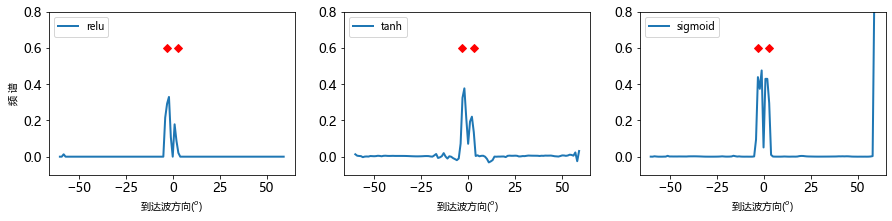

In [79]:
plt.rcParams['font.sans-serif']=['Microsoft YaHei']
figsize = 15,3
figure, ax = plt.subplots(figsize=figsize)

plt.subplot(131)
plt.plot(theta.T,(DCN1[:]),linewidth=2.0)
plt.ylim([-0.1,0.8])
plt.plot(DOA_train[:,k],np.ones((K,))*0.6,'rD')
plt.tick_params(labelsize=13)
plt.xlabel('到达波方向($^o$)')
plt.ylabel('频 谱') 
plt.legend(["relu"],loc='upper left')
#plt.show()

plt.subplot(132)
plt.plot(theta.T,(DCN2[:]),linewidth=2.0)
plt.ylim([-0.1,0.8])
plt.plot(DOA_train[:,k],np.ones((K,))*0.6,'rD')
plt.tick_params(labelsize=13)
#labels = ax.get_xticklabels() + ax.get_yticklabels()
plt.xlabel('到达波方向($^o$)')
plt.legend(["tanh"],loc='upper left')
#plt.ylabel('频 谱') 
#plt.show()

plt.subplot(133)
plt.plot(theta.T,(DCN3[:]),linewidth=2.0)
plt.ylim([-0.1,0.8])
plt.plot(DOA_train[:,k],np.ones((K,))*0.6,'rD')
plt.tick_params(labelsize=13)
#labels = ax.get_xticklabels() + ax.get_yticklabels()
plt.xlabel('到达波方向($^o$)')
#plt.ylabel('频 谱') 
plt.legend(["sigmoid"],loc='upper left')
#plt.show()



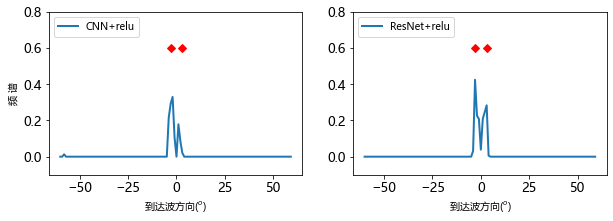

In [83]:
figsize = 10,3
figure, ax = plt.subplots(figsize=figsize)

plt.subplot(121)
plt.plot(theta.T,(DCN1[:]),linewidth=2.0)
plt.ylim([-0.1,0.8])
plt.plot(DOA_train[:,k],np.ones((K,))*0.6,'rD')
plt.tick_params(labelsize=13)
plt.xlabel('到达波方向($^o$)')
plt.ylabel('频 谱') 
plt.legend(["CNN+relu"],loc='upper left')

plt.subplot(122)
plt.plot(theta.T,(DCN4[:]),linewidth=2.0)
plt.ylim([-0.1,0.8])
plt.plot(DOA_train[:,k],np.ones((K,))*0.6,'rD')
plt.tick_params(labelsize=13)
#labels = ax.get_xticklabels() + ax.get_yticklabels()
plt.xlabel('到达波方向($^o$)')
plt.legend(["ResNet+relu"],loc='upper left')
#plt.ylabel('频 谱') 
#plt.show()